In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import numpy as np

## Dataset

In [2]:
def preprocess(imgs):
    imgs = (imgs - 127.5) / 127.5  # Normalize to [-1, 1]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2),), constant_values=-1)  # Pad to 32x32
    imgs = np.expand_dims(imgs, axis=-1)  # Add channel dimension
    return imgs

In [3]:
(x_train, _), (x_test, _) = datasets.mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)

BUFFER_SIZE = x_train.shape[0] # Buffer size for shuffling
BATCH_SIZE = 128 # Batch size for training

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)


2025-10-22 10:57:29.425900: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-10-22 10:57:29.425952: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-10-22 10:57:29.425959: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
I0000 00:00:1761152249.425979  385307 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1761152249.426013  385307 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Función de Energía

La función de energía es un modelo que asigna un valor escalar (energía) a cada configuración posible de las variables de entrada. En el contexto de imágenes, la función de energía puede ser utilizada para modelar la distribución de probabilidad de las imágenes.

$E(x; \theta)$ es una red neuronal parametrizada por $\theta$ que toma una imagen $x$ como entrada y produce un valor escalar que representa la "energía" de esa imagen.

Ese valor de energía puede interpretarse como una medida de cuán probable es que la imagen $x$ pertenezca a la distribución de datos que estamos modelando. Imágenes con baja energía son más probables, mientras que imágenes con alta energía son menos probables.

In [4]:
# Usaremos swish para la función de activación

swish = tf.keras.activations.swish

La función de activación swish es una función no lineal que se define como:
$$\text{swish}(x) = x \cdot \sigma(x)
$$donde $\sigma(x)$ es la función sigmoide dada por:
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Se trata de una alternativa a funciones de activación más comunes como ReLU o sigmoid, que tiene un comportamiento suave y puede atenuar el problema del "dying ReLU" (ReLU moribunda) al permitir que las neuronas tengan salidas negativas.

In [5]:
# Implementación de función de Energía

ebm_input = tf.keras.Input(shape=(32, 32, 1))
x = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding='same', activation=swish)(ebm_input)
x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation=swish)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation=swish)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation=swish)(x)
x = tf.keras.layers.Flatten()(x)
ebm_output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=ebm_input, outputs=ebm_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,481 (236.25 KB)

 Trainable params: 60,481 (236.25 KB)

 Non-trainable params: 0 (0.00 B)

## Muestreo con Dinámica Estocástica de Langevin

Lo que queremos entonces es generar nuevas imagenes de baja energía (es decir, imágenes que el modelo considere probables) a partir de la función de energía aprendida. Para esto utilizaremos la dinámica de Langevin, que es un método de muestreo basado en gradientes.

La dinámica de Langevin es un método utilizado para muestrear de distribuciones de probabilidad complejas, especialmente en el contexto de modelos generativos como los Modelos de Energía. La idea principal es utilizar gradientes de la función de energía para guiar el proceso de muestreo, combinando estos gradientes con ruido gaussiano para explorar el espacio de muestras.

Si la red neuronal que define la función de energía es diferenciable, podemos calcular el gradiente de la energía con respecto a la entrada $x$:
$$\nabla_x E(x; \theta)$$

Este gradiente indica la dirección en la que la energía aumenta más rápidamente. Para muestrear nuevas imágenes, comenzamos con una imagen inicial (que puede ser ruido aleatorio) y actualizamos iterativamente la imagen utilizando el gradiente de la energía y añadiendo ruido gaussiano:
$$x_{t} = x_{t-1} - \eta \nabla_x E(x_{t-1}; \theta) + \omega_t$$

donde $\eta$ es la tasa de aprendizaje (step size), $\omega_t$ es un término de ruido gaussiano que introduce aleatoriedad en el proceso de muestreo y $\omega_{0}$ es el ruido inicial.

Si la red neuronal está bien entrenada, este proceso de muestreo debería producir imágenes que son representativas de la distribución de datos original, es decir, imágenes que el modelo considera probables.

Esto quiere decir que el ruido original se va "refinando" gradualmente para convertirse en una imagen que tiene baja energía según la función de energía aprendida por el modelo y que por lo tanto es similar a las imágenes del conjunto de datos de entrenamiento.

Tabla de diferencia entre gradiente de descenso clásico y dinámica de Langevin: 

| Aspecto                       | Gradiente de Descenso Clásico | Dinámica Estocástica de Langevin |
|--------------------------------------|-------------------------------|----------------------------------|
| Se actualiza  | Los pesos de la red neuronal                  | La entrada (imagen)                       |
| Objetivo                          | Minimizar una función de pérdida específica | Muestrear de una distribución de probabilidad y minimizar la energía |
| Gradiente utilizado                | Gradiente de la función de pérdida $ \nabla_\theta L(\theta) $      | Gradiente de la función de energía   $ \nabla_x E(x; \theta) $ |
| Resultado |  Convergencia a un mínimo local de la función de pérdida | Generación de muestras que representan la distribución de datos |

En el caso de MNIST el "paisaje de energía" aprendido por el modelo debería tener valles profundos alrededor de las imágenes de dígitos manuscritos, y el proceso de muestreo debería llevarnos a esas regiones de baja energía, generando así nuevas imágenes de dígitos manuscritos. Este tiene 1024 dimensiones (28x28 píxeles).

## Interpretación

En el contexto de los Modelos de Energía, la función de energía $E(x; \theta)$ puede interpretarse como una medida de "compatibilidad" o "probabilidad" de una imagen $x$ dada la distribución de datos que el modelo ha aprendido. Imágenes con baja energía son consideradas más probables o más compatibles con la distribución de datos, mientras que imágenes con alta energía son menos probables.

Durante el proceso de muestreo utilizando la dinámica de Langevin, comenzamos con una imagen inicial (que puede ser ruido aleatorio) y actualizamos iterativamente esta imagen para reducir su energía según la función de energía aprendida por el modelo. Al hacerlo, estamos guiando la imagen hacia regiones del espacio de imágenes que el modelo considera más probables.

La adición de ruido gaussiano en cada paso del muestreo introduce aleatoriedad, lo que permite explorar diferentes regiones del espacio de imágenes y evita que el proceso quede atrapado en mínimos locales de energía. 

A medida que iteramos este proceso, cada paso reduce ligeramente la energía de la imagen, acercándola a una configuración más probable (con menor energía). Después de suficientes iteraciones, la imagen resultante debería ser una muestra representativa de la distribución de datos que el modelo ha aprendido, es decir, una imagen que el modelo considera probable. Es decir que son "esculpidas" gradualmente a partir del ruido inicial moviendose sobre el paisaje de energía aprendido por el modelo.


## Generando Nuevas Imágenes

In [6]:
def generate_samples(model, inp_imgs, steps, step_size, noise):
    
    # Iterar durante el número de pasos indicado.
    for _ in range(steps):  
        # Añadir una pequeña cantidad de ruido a la imagen.
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)

        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            # Pasar la imagen por el modelo para obtener el puntaje de energía.
            out_score = -model(inp_imgs)
        
        # Calcular el gradiente de la salida con respecto a la entrada.
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -0.03, 0.03)
        
        # Agregar una pequeña cantidad del gradiente a la imagen de entrada.
        inp_imgs += -step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)

    return inp_imgs


## Divergencia Contrastiva 

La Divergencia Contrastiva (CD) es un método de entrenamiento utilizado para ajustar los parámetros de modelos generativos, como los Modelos de Energía. La idea principal detrás de CD es aproximar el gradiente de la función de pérdida utilizando muestras generadas por el modelo en lugar de calcular el gradiente exacto, que puede ser computacionalmente costoso.

¿Qué queremos lograr con CD? Queremos ajustar los parámetros del modelo para que la distribución de probabilidad generada por el modelo se acerque a la distribución de probabilidad de los datos reales. Para lograr esto, CD utiliza dos conjuntos de muestras: uno de los datos reales y otro de las muestras generadas por el modelo. El objetivo es minimizar la diferencia entre estas dos distribuciones.

En otras palabras, queremos enseñar al modelo a asignar bajas energías (altas probabilidades) a las muestras reales y altas energías (bajas probabilidades) a las muestras falsas. Lo podemos ver como hacer que los datos reales se encuentren en los "valles" del paisaje de energía aprendido por el modelo, mientras que las muestras generadas por el modelo se encuentren en las "colinas" o regiones de alta energía.

El proceso de entrenamiento con CD generalmente implica los siguientes pasos:

1. **Muestreo de Datos Reales**: Se extraen un conjunto de muestras de los datos reales.
2. **Muestreo de Datos Falsos**: Se generan un conjunto de muestras a partir del modelo.
3. **Cálculo de Energías**: Se evalúan las energías de ambas conjuntos de muestras utilizando la función de energía del modelo.
4. **Actualización de Parámetros**: Se ajustan los parámetros del modelo para minimizar la diferencia entre las energías de las muestras reales y las generadas.

La Divergencia Contrastiva es especialmente útil en el contexto de los Modelos de Energía porque permite entrenar modelos complejos sin necesidad de calcular explícitamente la función de partición, que puede ser intractable en muchos casos. Al utilizar muestras generadas por el modelo, CD proporciona una forma eficiente de aproximar el gradiente necesario para actualizar los parámetros del modelo.

¿El problema de fondo? 

El principal desafío con la Divergencia Contrastiva es que las muestras generadas por el modelo pueden no ser representativas de la distribución real de los datos, especialmente en las primeras etapas del entrenamiento. Esto puede llevar a actualizaciones de parámetros que no mejoran efectivamente la calidad del modelo. Para mitigar este problema, a menudo se utilizan técnicas adicionales, como el muestreo más sofisticado o el uso de múltiples pasos de muestreo para generar las muestras falsas.

En teoria, lo que debemos hacer es maximizar la probabilidad de los datos reales bajo el modelo, lo que equivale a minimizar la energía de las muestras reales y maximizar la energía de las muestras generadas por el modelo. O sea, optimizar los parámetros del modelo para que las muestras reales tengan baja energía y las muestras generadas tengan alta energía. El asunto es que calcular el gradiente exacto de esta función de pérdida puede ser computacionalmente costoso, especialmente cuando la función de partición es intractable. 

Recordemos que la distribución de Boltzmann está dada por:
$$P(x; \theta) = \frac{e^{-E(x; \theta)}}{Z(\theta)}$$
donde $Z(\theta)$ es la función de partición, $Z(\theta) = \int e^{-E(x; \theta)} dx$ pero como dan miedo las integrales pensemos que es la suma sobre todas las posibles configuraciones de $x$:

$$Z(\theta) = \sum_{x} e^{-E(x; \theta)}$$

¿Entonces como le hacemos? 

De entrada los metodos numéricos de optimización basados en gradientes requieren calcular el gradiente de la función de pérdida con respecto a los parámetros del modelo (que no es tan sencillo en este caso por la función de partición intractable).

En el caso de los Modelos de Energía, esto implica calcular el gradiente de la log-verosimilitud (esto es $\nabla_{\theta} \log P(x; \theta)$) que a su vez requiere calcular expectativas sobre la distribución del modelo. Estas expectativas son difíciles de calcular directamente debido a la función de partición intractable. 

Recordemos que la log-verosimilitud está dada por:
$$\log P(x; \theta) = -E(x; \theta) - \log Z(\theta)$$
que es simplemente el logaritmo de la distribución de Boltzmann.


Lo que a la vez quiere decir que entonces tampoco podemos encontrar parámetros óptimos para el modelo. Es decir que no podemos usar Maximum Likelihood Estimation (MLE) o métodos de Monte Carlo directos para aproximar estas expectativas, porque necesitaríamos muestras de la distribución del modelo, que es precisamente lo que estamos tratando de aprender.

Recordemos también de la clase de ML que el MLE sirve para estimar los parámetros de un modelo estadístico de manera que la probabilidad de observar los datos que tenemos sea la mayor posible bajo ese modelo. En otras palabras, buscamos los parámetros que maximizan la verosimilitud de los datos observados. En este caso MLE implica maximizar la log-verosimilitud de los datos reales bajo el modelo, lo que equivale a minimizar la energía de las muestras reales y maximizar la energía de las muestras generadas por el modelo.

¿Entonces?

Aquí es donde la Divergencia Contrastiva proporciona una forma práctica de lograr esto mediante el uso de muestras generadas por el modelo para aproximar el gradiente necesario para actualizar los parámetros del modelo.

Para esto , en lugar de calcular el gradiente exacto de la log-verosimilitud, CD utiliza una aproximación basada en dos conjuntos de muestras: uno de los datos reales y otro de las muestras generadas por el modelo. El objetivo es minimizar la diferencia entre estas dos distribuciones.

Es decir, Aproxima el gradiente del aprendizaje mediante dos expectativas:

$$\nabla_{\theta} L(\theta) \approx \mathbb{E}_{x \sim P_{data}}[\nabla_{\theta} E(x; \theta)] - \mathbb{E}_{x \sim P_{model}}[\nabla_{\theta} E(x; \theta)]$$

El primer término $\mathbb{E}_{x \sim P_{data}}[\nabla_{\theta} E(x; \theta)]$ representa la contribución de las muestras reales, que queremos minimizar (baja energía), mientras que el segundo término $\mathbb{E}_{x \sim P_{model}}[\nabla_{\theta} E(x; \theta)]$ representa la contribución de las muestras generadas por el modelo, que queremos maximizar (alta energía).

> Nota: Recordemos que las muestras falsas se generan utilizando el mismo proceso de muestreo basado en gradientes descrito anteriormente (dinámica de Langevin), comenzando con ruido aleatorio y refinándolo gradualmente para producir muestras que el modelo considera probables.

El procedimiento en general es el siguiente:

1. Tomamos ejemplos del conjunto de datos real.
2. Generamos ejemplos "falsos" utilizando el modelo actual (usando dinámica de Langevin).
3. Calculamos las energías de ambos conjuntos de ejemplos y comparamos.
4. Actualizamos los parámetros $θ$ del modelo para reducir la energía de los ejemplos reales y aumentar la energía de los ejemplos falsos.

Para el paso 2, mantenemos un buffer de muestreo fijo.


```python
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, 32, 32, 1)) * 2 - 1
            for _ in range(128)
        ]  # (1) Crea 128 imágenes iniciales de ruido uniforme entre -1 y 1

    def sample_new_exmps(self, steps, step_size, noise):
        # (2) Calcula cuántas muestras nuevas generar (5% del total)
        n_new = np.random.binomial(128, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, 32, 32, 1)) * 2 - 1
        )
        
        # (3) El 95% restante se toma del buffer existente
        old_imgs = tf.concat(
            random.choices(self.examples, k=128 - n_new),
            axis=0
        )

        # Concatenar imágenes nuevas y viejas
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)

        # (4) Refinar imágenes mediante el muestreador de Langevin
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )

        # (5) Actualizar el buffer (mantener máximo 8192 ejemplos)
        self.examples = tf.split(inp_imgs, 128, axis=0) + self.examples
        self.examples = self.examples[:8192]

        return inp_imgs
```

In [7]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.size = 128
        self.max_size = 8192
        # Inicializa el buffer como una variable de TensorFlow
        self.examples = tf.Variable(
            tf.random.uniform(shape=(self.size, 32, 32, 1), minval=-1, maxval=1, dtype=tf.float32),
            trainable=False
        )

    @tf.function
    def sample_new_exmps(self, steps, step_size, noise):
        n_new = tf.cast(tf.round(0.05 * self.size), tf.int32)  # 5% de 128 = 6
        n_old = self.size - n_new
        # Selecciona índices aleatorios del buffer para las muestras viejas
        idx = tf.random.uniform((n_old,), minval=0, maxval=tf.shape(self.examples)[0], dtype=tf.int32)
        old_imgs = tf.gather(self.examples, idx)
        # Genera nuevas imágenes aleatorias
        rand_imgs = tf.random.uniform((n_new, 32, 32, 1), minval=-1, maxval=1, dtype=tf.float32)
        # Concatenar imágenes nuevas y viejas
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        # Refinar imágenes mediante el muestreador de Langevin
        inp_imgs = generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise)
        # Actualizar el buffer: reemplazar las primeras n_new posiciones con las nuevas imágenes generadas
        updated_buffer = tf.concat([inp_imgs[:n_new], self.examples[n_new:]], axis=0)
        self.examples.assign(updated_buffer[:self.size])
        return inp_imgs


Ahora juntemos todo lo anterior

In [8]:
class EBM(tf.keras.models.Model):
    def __init__(self, model):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = 0.1

        # Métricas
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.reg_loss_metric = tf.keras.metrics.Mean(name="reg")
        self.cdiv_loss_metric = tf.keras.metrics.Mean(name="cdiv")
        self.real_out_metric = tf.keras.metrics.Mean(name="real")
        self.fake_out_metric = tf.keras.metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs = tf.cast(real_imgs, tf.float32)
        # Añade ruido leve a las imágenes reales
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=0.005
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)

        # Genera muestras falsas desde el buffer
        fake_imgs = self.buffer.sample_new_exmps(
            steps=100, step_size=10, noise=0.005
        )

        # Junta ambos conjuntos
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)

        # === Cálculo de pérdidas y actualización ===
        with tf.GradientTape() as training_tape:
            # (3) Evalúa energías del modelo para reales y falsas
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)

            # (4) Pérdida contrastiva: diferencia de energías promedio
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)

            # (5) Regularización (penaliza magnitudes grandes)
            reg_loss = self.alpha * tf.reduce_mean(real_out**2 + fake_out**2, axis=0)

            # Pérdida total
            loss = reg_loss + cdiv_loss

        # (6) Retropropagación y actualización de pesos
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        # (7) Actualización de métricas
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        # Genera imágenes falsas aleatorias para evaluación
        batch_size = real_imgs.shape[0]
        fake_imgs = tf.random.uniform((batch_size, 32, 32, 1)) * 2 - 1

        # Junta reales y falsas
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)

        # Calcula energías sin actualizar pesos
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(real_out, axis=0) - tf.reduce_mean(fake_out, axis=0)

        # Actualiza métricas relevantes para validación
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        # Devuelve un diccionario con los valores actuales de métricas
        return {m.name: m.result() for m in self.metrics[2:]}


In [9]:
ebm = EBM(model)

In [10]:
ebm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [11]:
ebm.fit(train_dataset, epochs=10)

Epoch 1/10


2025-10-22 10:57:35.809586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - cdiv: -0.7535 - fake: 0.1281 - loss: -0.4971 - real: 0.8815 - reg: 0.2563
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - cdiv: -0.7535 - fake: 0.1281 - loss: -0.4971 - real: 0.8815 - reg: 0.2563
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 164ms/step - cdiv: -0.0432 - fake: -0.0263 - loss: 0.0017 - real: 0.0169 - reg: 0.0449
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 164ms/step - cdiv: -0.0432 - fake: -0.0263 - loss: 0.0017 - real: 0.0169 - reg: 0.0449
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - cdiv: -0.0382 - fake: -0.0174 - loss: -0.0193 - real: 0.0208 - reg: 0.0189
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - cdiv: -0.0382 - fake: -0.0174 - loss: -0.0193 - real: 0.0208 - reg: 0.0189
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 165ms/step - cdiv: -0.0478 - fake: -0.0213 - loss: -0.0265 - real: 0.0265 - reg: 0.0213
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 165ms/step - cdiv: -0.0478 - fake: -0.0213 - 

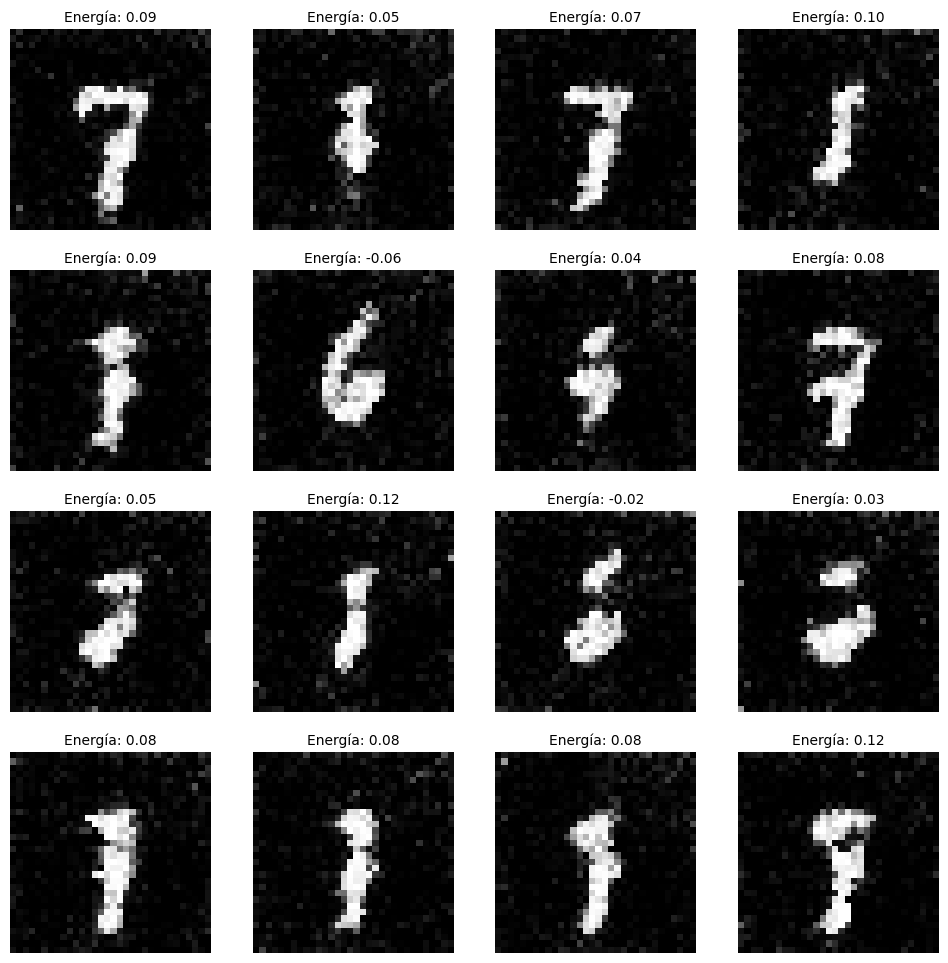

In [12]:
# Ahora que ya tenemos el modelo entrenado, podemos generar nuevas muestras
sampled_imgs = generate_samples(
    ebm.model,
    inp_imgs=tf.random.uniform((16, 32, 32, 1)) * 2 -1,
    steps=2000,
    step_size=2,
    noise=0.05
)

# Calcular energía de cada imagen generada
energies = ebm.model(sampled_imgs).numpy().flatten()

# Plot samples

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow((sampled_imgs[i, :, :, 0] + 1) / 2, cmap='gray')
    plt.title(f"Energía: {energies[i]:.2f}", fontsize=10)
    plt.axis('off')
plt.show()